<a href="https://colab.research.google.com/github/K0SATIN/Data-analyst-home-task/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Введение**

Для итоговой работы в сфере аналитики данных мной был выбран датасет по игрокам в StarCraft 2.

Целью работы были ознакомление с исходными данными, выявить основные закономерности и зависимости, определить их степень взаимозависимости, выявить основные числовые характеристики и степень их влияния на распределение игроков по лигам, распределение самих характеристик по лигам. Определение потенциала для дальнейших исследований.

На целеполагание повлияла в первую очередь тематика датасета. Тема геймдизайна мне ближе в силу личных причин, чем, скажем, больных и пациентов в больнице. Также я вдохновлялся разборами этого датасета на Kaggle.com, однако по моему мнению там оставались недораскрытые моменты.

Краткое описание и контекст данных оставляли мало возможности для предсказательной аналитики. Во-первых, репрезентативность выборки неизвестна, мы не можем судить о том, сможет ли обученная модель предсказаний быть актуальной на иных данных. Также - мы не можем судить о взаимосвязях и их степени пока их не увидим. Взаимосвязи могут быть выражены слабо или отсутствовать вовсе. Нам может не хватать данных. Временной ряд тут не построить за отсуствием, собственно, времени. В данном случае был выбран подход "Сперва посмотрим, а там посмотрим". В начале работы я имел следующие предположения: при прочих равных будет корреляция между юнитами-кастерами, такими как заразитель, и рейтингом. Причина - они более требовательны к микроконтролю. Опытные игроки имеют менее широкий используемый ростер чем менее опытные - сказывается мета баланса. В дальнейшем мы обнаружим что ни одно из этих предположений не оказалось верным. За основу было взято, что если соотношение игроков между лигами может быть не репрезентативно, то распределение игроков внутри лиги будет лучше характеризовать лигу в целом.

В рамках целей были определены следующие задачи:

1) Получить плотность распределения основных величин относительно дифференциации по лигам.

2) Выявить особенности распределения плотности вероятности по лигам. Определить лиги со схожей плотностью вероятности

3) Получить основные характеристики, величины которых являются характерными для игроков разных лиг.

4) Определить величину корреляции между параметрами.

5) При наличие высокой корреляции составить модель их корреляции

6) При отсутствие параметров с высокой корреляцией выбрать параметры с наибольшей корреляцией и описать особенности закономерности их корреляции с дифференциацией по лигам/группам лиг.
За высокую корреляцию считаем от 0,85 и выше.

7) При отсутствие возможности статистически подтверждённых утверждений выдвинуть цепочку предположений и описать условия для их подтверждения.

**Используемые ресурсы**

Эта часть довольно скучная и состоит из подключения библиотек и датасета. Использовать мы будем преимущественно Pandas, однако часть функционала нам понадобится и из PySpark. Но производительность нам понадобится больше. К сожалению, мне пришлось обойтись без PySpark потому что нужно было разгрузить блокнот, потому что его зависания поставили под вопрос дальнейшие изыскания примерно на середине.

In [ ]:
!wget -q https://gitlab.com/K0SATIN/store/-/raw/master/SkillCraft1_Dataset.csv

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
import scipy.stats as stats
import pylab

Собственно, о самом датасете.
Он описывает игроков в StarCraft 2, ряд их измеряемых параметров. Разумеется, у нас остаются некоторые "тёмные данные" - например, выигрыш или проигрыш игрока в данном матче, качество принимаемых решений, время матча, etc.
Сразу дам пояснение к ряду ключевых терминов, которыми он опперирует:
- timestamps - "- Время записывается в виде временных меток в файле воспроизведения StarCraft 2. При воспроизведении игры на "более быстром" режиме 1 секунда реального времени эквивалентна примерно 88,5 временным меткам."
- PAC - цикл "раздражитель - реакция на раздражитель", является мерой скорости мышления
Про лиги StarCraft 2:
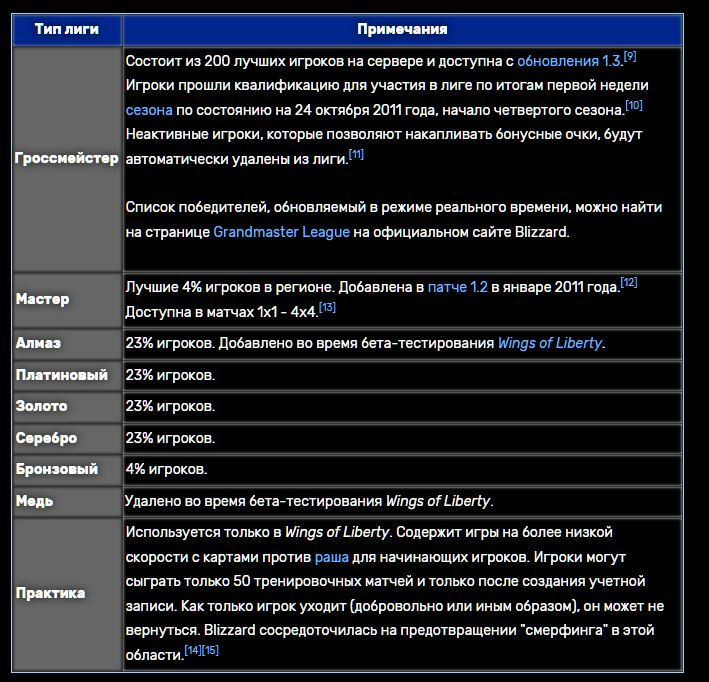

Существуют некоторые разночтения относительно того, как именно проиндексированы лиги в датасете. Согласно одному источнику:
1 Bronze
2 Silver
3 Gold
4 Platinum
5 Diamond
6 Master
7 Grand Master
Тогда как в описание к раздаче указывается как
Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
С учётом того что в датасете нет индекса 8, в описание к лигам на официальном сайте игры GrandMaster является высшей лигой остаётся загадкой зачем автор указал в описание лишнюю лигу.
Также отмечу что часть столбцов, от которых не ожидалось никаких откровений, была удалена.

In [ ]:
sc_pandas = pd.read_csv('/content/SkillCraft1_Dataset.csv')
sc_pandas.head(5)

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


Attribute Information:

1. GameID: Unique ID number for each game (integer)
2. LeagueIndex: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
3. Age: Age of each player (integer)
4. HoursPerWeek: Reported hours spent playing per week (integer)
5. TotalHours: Reported total hours spent playing (integer)
6. APM: Action per minute (continuous)
7. SelectByHotkeys: Number of unit or building selections made using hotkeys per timestamp (continuous)
8. AssignToHotkeys: Number of units or buildings assigned to hotkeys per timestamp (continuous)
9. UniqueHotkeys: Number of unique hotkeys used per timestamp (continuous)
10. MinimapAttacks: Number of attack actions on minimap per timestamp (continuous)
11. MinimapRightClicks: number of right-clicks on minimap per timestamp (continuous)
12. NumberOfPACs: Number of PACs per timestamp (continuous)
13. GapBetweenPACs: Mean duration in milliseconds between PACs (continuous)
14. ActionLatency: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)
15. ActionsInPAC: Mean number of actions within each PAC (continuous)
16. TotalMapExplored: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)
17. WorkersMade: Number of SCVs, drones, and probes trained per timestamp (continuous)
18. UniqueUnitsMade: Unique unites made per timestamp (continuous)
19. ComplexUnitsMade: Number of ghosts, infestors, and high templars trained per timestamp (continuous)
20. ComplexAbilitiesUsed: Abilities requiring specific targeting instructions used per timestamp (continuous)

Яндекс ужасно переводит описание столбцов. Уж как есть
1. GameID: уникальный идентификационный номер для каждой игры (целое число)
2. LeagueIndex: Бронзовая, серебряная, золотая, платиновая, бриллиантовая, Мастер, гроссмейстер и профессиональные лиги с кодировкой 1-8 (порядковый номер)
3. Age: возраст каждого игрока (целое число)
4. HoursPerWeek: количество часов, затраченных на игру в неделю (целое число)
5. TotalHours: сообщенное общее количество часов, затраченных на игру (целое число)
6. APM: количество действий в минуту (непрерывно)
7. SelectByHotkeys: количество выбранных объектов или зданий, сделанных с помощью горячих клавиш, за одну временную метку (непрерывно)
8. AssignToHotkeys: количество единиц или зданий, назначенных горячим клавишам за временную метку (непрерывно)
9. UniqueHotkeys: количество уникальных горячих клавиш, используемых для каждой временной метки (непрерывно)
10. TotalMapExplored: количество действий по атаке на мини-карте за одну временную метку (непрерывно)
11. MinimapRightClicks: количество щелчков правой кнопкой мыши по миникарте за одну временную метку (непрерывно)
12. NumberOfPACs: количество PACS на временную метку (непрерывное)
13. GapBetweenPACs: средняя продолжительность в миллисекундах между паками (непрерывный)
14. ActionLatency: средняя задержка от начала выполнения PACS до их первого действия в миллисекундах (непрерывно)
15. ActionsInPAC: среднее количество действий в каждом PAC (непрерывное)
16. TotalMapExplored: количество игровых координатных сеток 24x24, просмотренных игроком за одну временную метку (непрерывно)
17. WorkersMade: количество обученных SCV, дронов и зондов за одну временную метку (непрерывно)
18. UniqueUnitsMade: уникальные объединения, выполненные за временную метку (непрерывно)
19. ComplexUnitsMade: количество призраков, зараженных и высших тамплиеров, обученных за одну временную метку (непрерывно)
20. ComplexAbilitiesUsed: способности, требующие специальных инструкций по таргетингу, используемых для каждой временной метки (непрерывно)

**Подготовка данных**

In [ ]:
inval_dtypecol = ['LeagueIndex', 'HoursPerWeek', 'APM','MinimapAttacks','TotalMapExplored','WorkersMade','ComplexAbilitiesUsed',
                  'SelectByHotkeys','AssignToHotkeys', 'UniqueUnitsMade', 'ComplexUnitsMade']
sc_pandas[inval_dtypecol] = sc_pandas[inval_dtypecol].apply(lambda x: x.replace("?", np.nan))
for col in inval_dtypecol:
    sc_pandas[col] = pd.to_numeric(sc_pandas[col])

In [ ]:
#selectedColumns = ['LeagueIndex', 'HoursPerWeek', 'APM','MinimapAttacks','TotalMapExplored','WorkersMade','ComplexAbilitiesUsed','SelectByHotkeys','AssignToHotkeys', 'UniqueUnitsMade', 'ComplexUnitsMade']
selectedColumns = ['LeagueIndex', 'HoursPerWeek', 'APM','MinimapAttacks','TotalMapExplored','WorkersMade',
                  'SelectByHotkeys','AssignToHotkeys', 'UniqueUnitsMade', 'ComplexUnitsMade',
                  'NumberOfPACs',	'ActionsInPAC']
sc_pandas = sc_pandas[selectedColumns].dropna()

Здесь мы немного чистим датасет от скомпрометированных строчек

In [ ]:
sc_pandas.head(3)

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
0,5,10.0,143.7180,0.000110,28,0.001397,0.003515,0.000220,6,0.0,0.004849,4.7508
1,5,10.0,129.2322,0.000294,22,0.001193,0.003304,0.000259,5,0.0,0.004307,4.8434
2,4,10.0,69.9612,0.000294,22,0.000745,0.001101,0.000336,6,0.0,0.002926,4.0430


In [ ]:
sc_pandas.describe()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
count,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000,3339.000000
mean,4.120994,15.910752,114.569743,0.000094,22.119497,0.001031,0.004023,0.000364,6.541180,0.000060,0.003434,5.266305
std,1.448033,11.962912,48.105963,0.000159,7.441349,0.000520,0.004726,0.000210,1.858787,0.000111,0.000966,1.500850
min,1.000000,0.000000,22.059600,0.000000,5.000000,0.000077,0.000000,0.000000,2.000000,0.000000,0.000679,2.038900
25%,3.000000,8.000000,79.233600,0.000000,17.000000,0.000682,0.001246,0.000202,5.000000,0.000000,0.002743,4.261200
50%,4.000000,12.000000,107.067600,0.000039,22.000000,0.000904,0.002447,0.000349,6.000000,0.000000,0.003377,5.086800
75%,5.000000,20.000000,140.134200,0.000113,27.000000,0.001258,0.004943,0.000493,8.000000,0.000087,0.004004,6.027200
max,7.000000,168.000000,389.831400,0.003019,58.000000,0.005149,0.043088,0.001648,13.000000,0.000902,0.007971,18.558100


Наконец, что-то уже поинтереснее. Начнём с того, что 168 часов - это сумма всех часов за неделю. Участвуют ли боты в рейтинге? Может ли под одним игроком играть несколько человек?
Среднее значение индекса лиги примерно равно 4, но зная как эти индексы составляются, не думаю что это новость.
Остальные значения пока что для нас малоинтересны - куда интереснее как они будут разбиваться по лигам

Я думаю что будет неплохо посмотреть график плотности вероятности по ключевым параметрам

<Axes: title={'center': 'Плотность распределения АРМ'}, xlabel='APM', ylabel='Density'>

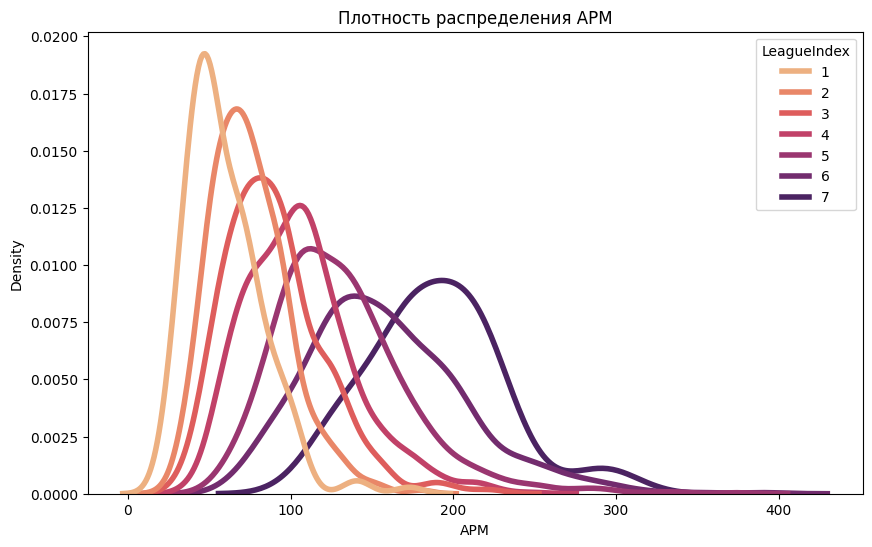

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Плотность распределения АРМ')
sns.kdeplot(data=sc_pandas, x="APM", hue = 'LeagueIndex', palette= "flare", common_norm = False, lw = 4)

В принципе, ожидаемо. В дальнейшем мы ещё это увидим, но плотность вероятности имеет схожую сигнатуру у лиг с 1 по 3, 5-6 можно считать отдельной группой, наконец, плотность вероятности грандмастеров живёт своей отдельной жизнью, как и лига 5.
АРМ считается важнейшим параметром среди геймеров, и в дальнейшем мы увидим почему.
Также можно заметить, что если плотность вероятности у лиг 1-3 имеет ярко выраженный крутой пик, но лиги с 5-6 имеет ярко выраженный спуск, отражающий что у нас также есть неплохой шанс найти там игроков с высоким АРМ. Напротив, у лиги 7 есть пологий подъём. Существует достаточно большая группа игроков, особенно в Мастер Лиге, по АРМ близких к слабейшей половине Грандмастеров. В то же время есть условная стенка из АРМ, разделяющая игроков по лигам. Стенка размывается чем лига выше, но на младших лигах существует строгая градация.

<Axes: title={'center': 'Плотность распределения создания уникальных юнитов'}, xlabel='UniqueUnitsMade', ylabel='Density'>

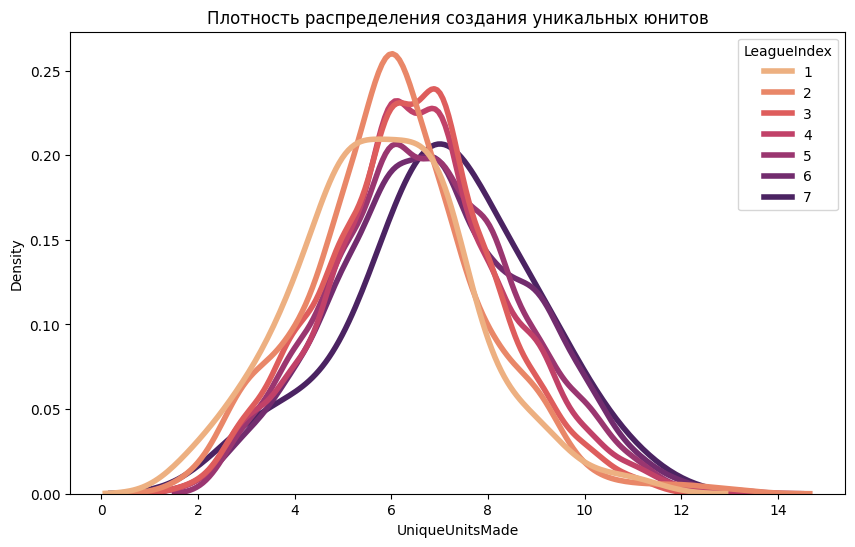

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Плотность распределения создания уникальных юнитов')
sns.kdeplot(data=sc_pandas, x="UniqueUnitsMade", hue = 'LeagueIndex', palette= "flare", common_norm = False, lw = 4)

А вот это было неожиданно. Я предполагал что часть юнитов является лишними в линейке юнитов, и игроки, которые не знают что строить, будут строить всё подряд, тогда как "элита" будет играть менее разнообразным составом. При всех плюсах баланса StarCraft 2 - патчи выходят редко и в каждом патче есть свои любимчики разработчиков.
С другой стороны, мы не можем сказать - в каких случаях игроки элементарно доживают до лейта. Отсутствие контекста данных является препятствием для точного анализа, в данном случае это так. А пока мы наблюдаем кашу, игроки играют +- одинаковым номинально составом по разнообразию.

<Axes: title={'center': 'Плотность распределения использования горячих клавиш'}, xlabel='SelectByHotkeys', ylabel='Density'>

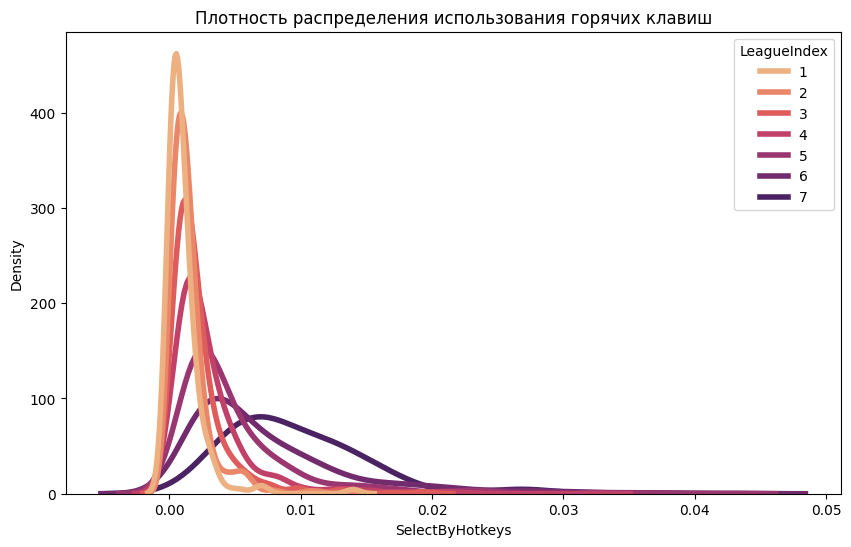

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Плотность распределения использования горячих клавиш')
sns.kdeplot(data=sc_pandas, x="SelectByHotkeys", hue = 'LeagueIndex', palette= "flare", common_norm = False, lw = 4)

Очередной пример того, что в StarCraft 2 можно всадить ещё парочку лиг уровня "выше среднего". Но на самом деле этого никто не будет делать, и не потому что разработчики прикрыли поддержку игры. Переход из "Бронзы" в "Серебро" является "конфеткой" - это награда игрока за минимальный прогресс, которая должна мотивировать его играть дальше. Но к анализу данных это имеет мало отношения, и мы всё также наблюдаем ярко выраженные пики у игроков "младших" лиг, указывающие на то, что горячими клавишами в большинстве случаев они пользуются примерно никогда.
Чем старше лига, тем более пологим становится график, с более плавными спусками. Если бы целью лиг было разделить игроков по частоте использования горячих клавиш, то лигу "Мастер" и "Грандмастер" можно было бы поделить надвое, получив из лиги "Грандмастер" дополнительную "Убийца клавиатуры".

<Axes: title={'center': 'Плотность распределения размера открытой карты'}, xlabel='TotalMapExplored', ylabel='Density'>

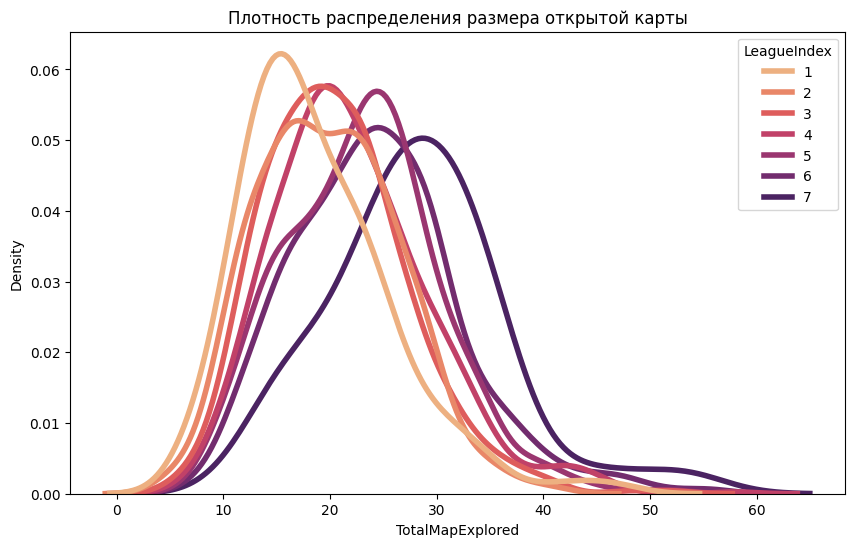

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Плотность распределения размера открытой карты')
sns.kdeplot(data=sc_pandas, x="TotalMapExplored", hue = 'LeagueIndex', palette= "flare", common_norm = False, lw = 4)

Картина в целом похожая на АРМ, хотя сдвиг меньше и нет таких крутых пиков(проще говоря, игроки чаще следят за картой, чем быстро реагируют). Также обращает на себя внимание одна из причин моего желания слить лиги с 1 по 3(как минимум) в одну. Можно разбить группы лиг на "Новичок" - 1 лига, "Воитель" - 2-4 лига и "Ветеран" - 5-6, "Убийца" из "Грандмастер". Также как и с АРМ последняя демонстрирует пологий подъём.

<Axes: title={'center': 'Плотность распределения создания рабочих'}, xlabel='WorkersMade', ylabel='Density'>

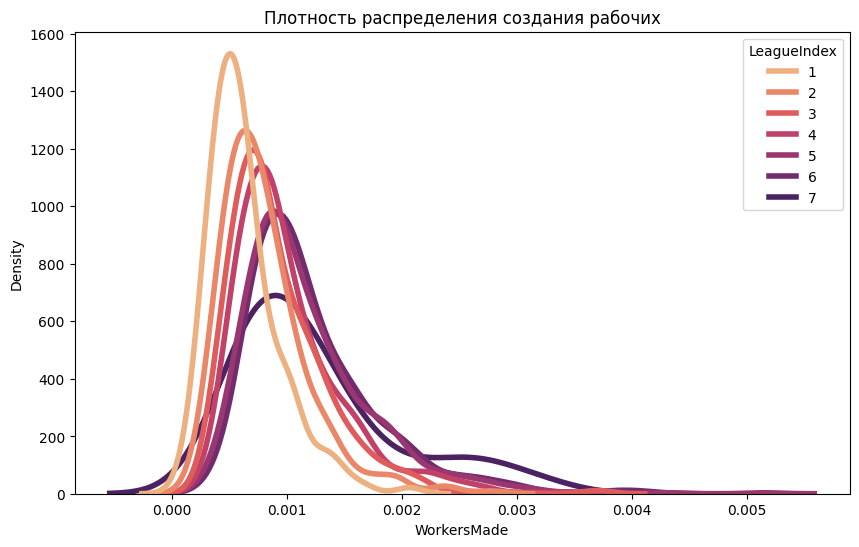

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Плотность распределения создания рабочих')
sns.kdeplot(data=sc_pandas, x="WorkersMade", hue = 'LeagueIndex', palette= "flare", common_norm = False, lw = 4)

Отсутствие контекста тут особенно мешает, но я предположу, что среди грандмастеров больше любителей поиграть в макро, но также есть и любители закончить игру быстро. Рост дозаказа рабочих может указывать как на активное расширение, так и на огромные потери из-за неспособности защитить добычу.

<Axes: title={'center': 'Плотность распределения создания групп'}, xlabel='AssignToHotkeys', ylabel='Density'>

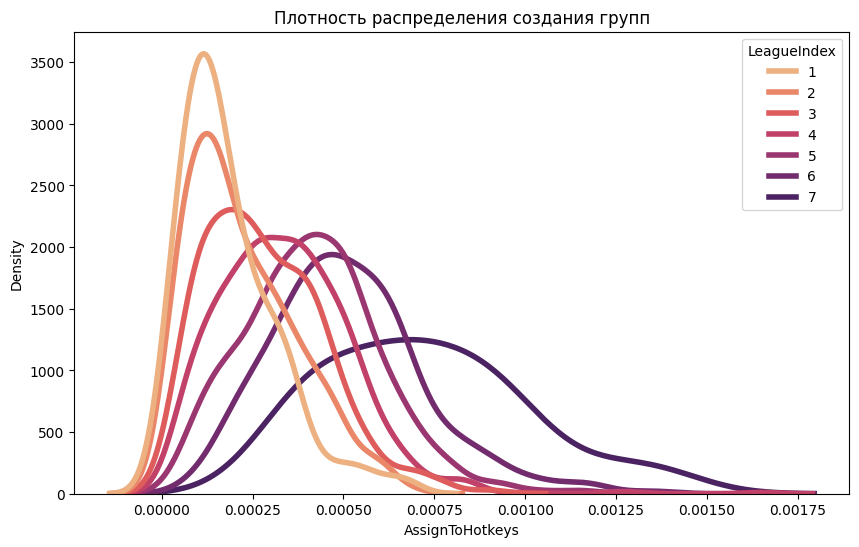

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Плотность распределения создания групп')
sns.kdeplot(data=sc_pandas, x="AssignToHotkeys", hue = 'LeagueIndex', palette= "flare", common_norm = False, lw = 4)

В общем случае мы наблюдаем сдвиг со спусокм. Параметры игроков не только растут количественно, но изменяет тип их распределения в сторону большего рассеивания по значениям. Всего наблюдается 3 паттерна - "Младшая лига", "Старшая лига" и "Грандмастер". При этом рассевание переходти на качественно новый уровень с "Грандмастерами", причём зачастую оно носит характер деградации. Проще говоря, часть игроков "Грандмастер" лиги могут прокатить за сильнейшее меньшинство "младшей лиги", ну а сильнейшая примерно 1/4 "Старшей лиги" может прокатить за "Грандмастеров". Естественно, если брать табличные параметры. Картина с "Назначением горячих клавиш" тут мало что меняет.

<Axes: title={'center': 'Плотность распределения РАС'}, xlabel='NumberOfPACs', ylabel='Density'>

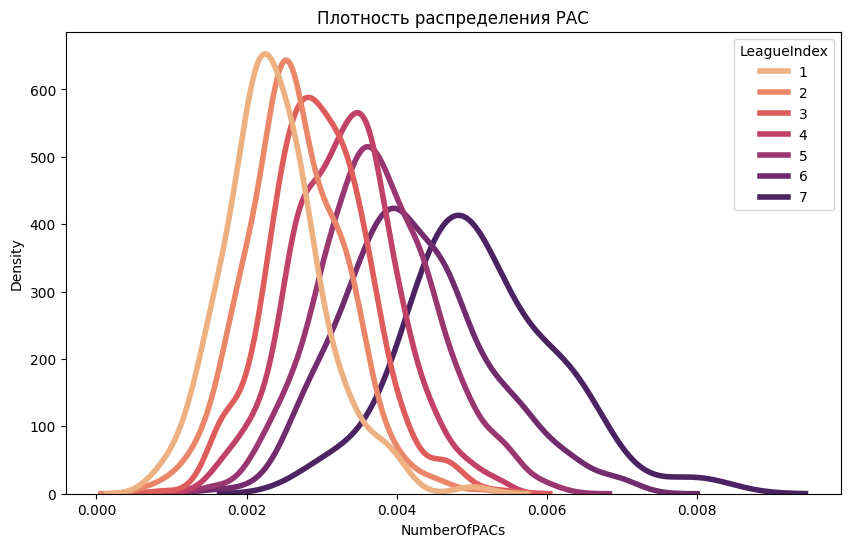

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Плотность распределения РАС')
sns.kdeplot(data=sc_pandas, x="NumberOfPACs", hue = 'LeagueIndex', palette= "flare", common_norm = False, lw = 4)

Однако, справедливости ради, в случае с "Грандмастерами" практически всегда наблюдается заметный сдиг. Да, "Мастер" может быть быстрее(в случае с РАС) не самой быстрой части "Грандмастеров", но это должен быть быстрый "Мастер". Другой вопрос, что наблюдаемый разрыв между "Мастерами" и, скажем, "Платиной" или тем более "Золотом" будет непропорционально иным, да и структура выборки там меняется.
Картина наводит меня на мысль что РАС является АРМ-зависимой величиной. Или наоборот? На самом деле, скорее всего игроки сперва быстро думают, а уже потом быстро делают. Обращает на себя внимание огромный разрыв по площади области графика у "Грандмастеров". Возможно, что основное отличие их от "смертных" и заключается в как правило большем РАС. Это может натолкнуть нас на рассуждения о сущности стратегий в реальном времени с точки зрения психологической/психической активности, но тут я не специалист.

<Axes: title={'center': 'Плотность распределения действий в одном цикле РАС'}, xlabel='ActionsInPAC', ylabel='Density'>

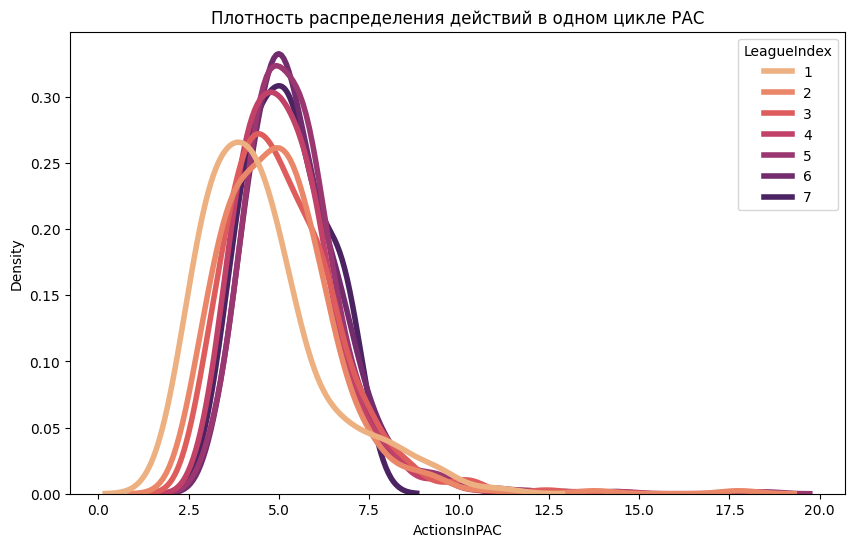

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Плотность распределения действий в одном цикле РАС')
sns.kdeplot(data=sc_pandas, x="ActionsInPAC", hue = 'LeagueIndex', palette= "flare", common_norm = False, lw = 4)

С другой стороны, количество действий в РАС остаётся неизменной. Играет роль только количество РАС. "Младшая лига" в редких случаях склонна совершать больше действий, новички - меньше. Это наводит на мысль что некоторые действия могут быть порождены психологическим состоянием, а не рассчётом. Проще говоря, игрок паникует.

**Разведочный анализ данных и поиск корреляций**

In [ ]:
sc_pandas.head(1)

In [ ]:
grouped = sc_pandas.groupby(sc_pandas.LeagueIndex)
sc_L7 = grouped.get_group(7)
sc_L7.describe()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
count,35.0,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,7.0,31.714286,189.555686,0.000340,28.028571,0.001238,0.009418,0.000723,7.028571,0.000082,0.005111,5.226089
std,0.0,20.626327,40.792493,0.000304,8.114931,0.000697,0.004987,0.000277,1.901790,0.000125,0.000997,1.078309
min,7.0,6.000000,115.755600,0.000010,14.000000,0.000484,0.002693,0.000310,3.000000,0.000000,0.003108,3.322100
25%,7.0,15.000000,168.121500,0.000138,24.500000,0.000711,0.005737,0.000497,6.000000,0.000000,0.004535,4.344950
50%,7.0,28.000000,185.342400,0.000241,28.000000,0.001009,0.008216,0.000698,7.000000,0.000000,0.004952,5.306200
75%,7.0,42.000000,212.375100,0.000394,33.000000,0.001429,0.011948,0.000894,8.000000,0.000121,0.005636,6.074400
max,7.0,98.000000,298.795200,0.001164,53.000000,0.003191,0.026770,0.001387,11.000000,0.000386,0.007971,7.236400


Первое что я хочу сделать - это выделить "Грандмастеров" в отдельную группу.
Что можно сказать - в этой группе весьма высокое значение APM, также достаточно высокое значение std для APM. Рассеивание основных величин является препятствием для строительства эффективных предсказаний.

In [ ]:
sc_L7.corr()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
LeagueIndex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HoursPerWeek,NaN,1.000000,0.150747,-0.178617,0.066471,0.093759,0.175858,0.180036,0.277635,0.329950,0.314361,-0.161327
APM,NaN,0.150747,1.000000,-0.004267,0.016019,0.314784,0.783186,0.185762,-0.267816,-0.155476,0.312932,0.364654
MinimapAttacks,NaN,-0.178617,-0.004267,1.000000,0.301821,-0.011336,-0.138031,0.002671,0.066963,-0.124289,-0.112595,0.206435
TotalMapExplored,NaN,0.066471,0.016019,0.301821,1.000000,-0.089329,-0.051464,0.104308,0.506884,0.357526,0.258653,-0.156131
WorkersMade,NaN,0.093759,0.314784,-0.011336,-0.089329,1.000000,-0.011128,0.066880,0.114400,-0.070792,0.141995,0.247710
SelectByHotkeys,NaN,0.175858,0.783186,-0.138031,-0.051464,-0.011128,1.000000,0.060057,-0.149744,-0.077228,0.126340,0.082615
AssignToHotkeys,NaN,0.180036,0.185762,0.002671,0.104308,0.066880,0.060057,1.000000,-0.282485,0.161061,0.121298,0.105230
UniqueUnitsMade,NaN,0.277635,-0.267816,0.066963,0.506884,0.114400,-0.149744,-0.282485,1.000000,0.384553,0.314110,-0.534785
ComplexUnitsMade,NaN,0.329950,-0.155476,-0.124289,0.357526,-0.070792,-0.077228,0.161061,0.384553,1.000000,0.100499,-0.218537


Поиск корреляций выявил на удивление мало хороших корреляций. Практически никакой корреляции между АРМ и числом игр в неделю, но хорошая корреляция между горячими клавишами и АРМ. В принципе, это всё что нужно знать о высоком АРМ у геймеров. Число РАС и АРМ даёт на удивление малую корреляцию, но лучше чем в большинстве случаев в таблице

In [ ]:
grouped = sc_pandas.groupby(sc_pandas.LeagueIndex)
sc_L2 = grouped.get_group(2)
sc_L2.describe()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
count,347.0,347.00000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,2.0,13.29683,74.780917,0.000045,19.824207,0.000801,0.001536,0.000222,6.074928,0.000024,0.002650,5.005949
std,0.0,9.59474,23.855401,0.000089,6.513720,0.000388,0.001663,0.000148,1.783071,0.000071,0.000664,1.653597
min,2.0,2.00000,24.664800,0.000000,5.000000,0.000165,0.000000,0.000000,2.000000,0.000000,0.000679,2.395500
25%,2.0,8.00000,57.214200,0.000000,15.000000,0.000537,0.000581,0.000106,5.000000,0.000000,0.002246,3.858550
50%,2.0,10.00000,71.675400,0.000014,20.000000,0.000723,0.001095,0.000186,6.000000,0.000000,0.002597,4.879000
75%,2.0,18.00000,89.213100,0.000045,24.000000,0.000953,0.001847,0.000321,7.000000,0.000000,0.003075,5.779650
max,2.0,72.00000,179.625000,0.000879,41.000000,0.002772,0.013991,0.000690,13.000000,0.000494,0.005138,17.761900


In [ ]:
sc_L2.corr()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
LeagueIndex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HoursPerWeek,NaN,1.000000,0.126187,-0.074256,-0.008273,-0.049159,0.125140,0.037628,0.004778,0.023308,0.075505,0.067854
APM,NaN,0.126187,1.000000,0.043492,0.230052,0.388882,0.582970,0.252289,0.117733,0.146841,0.519816,0.410787
MinimapAttacks,NaN,-0.074256,0.043492,1.000000,0.020973,-0.033825,-0.034944,-0.024678,0.025760,-0.025913,-0.037602,0.078901
TotalMapExplored,NaN,-0.008273,0.230052,0.020973,1.000000,0.052553,0.107634,0.073263,0.517985,0.262109,0.379754,-0.157048
WorkersMade,NaN,-0.049159,0.388882,-0.033825,0.052553,1.000000,0.165303,0.057641,0.017923,0.122245,0.096331,0.285344
SelectByHotkeys,NaN,0.125140,0.582970,-0.034944,0.107634,0.165303,1.000000,0.472916,0.069722,-0.011556,0.249260,0.042134
AssignToHotkeys,NaN,0.037628,0.252289,-0.024678,0.073263,0.057641,0.472916,1.000000,0.153672,0.071438,0.235519,-0.065413
UniqueUnitsMade,NaN,0.004778,0.117733,0.025760,0.517985,0.017923,0.069722,0.153672,1.000000,0.324762,0.256860,-0.124860
ComplexUnitsMade,NaN,0.023308,0.146841,-0.025913,0.262109,0.122245,-0.011556,0.071438,0.324762,1.000000,0.250103,-0.025313


Как и обещалось, быстрейшие из игроков уже "Серебра" могут посоперничать по АРМ с "Грандмастерами". Однако в большинстве своём их АРМ имеет слабую корреляцию с горячими клавишами(для данной величины у других групп). Проще говоря, это именно что потенциал для роста "Серебра" дальше. Можно предположить что число РАС наиболее связано с разведкой карты, и неожиданно сравнительно высокая корреляция открытой карты и разнообразия юнитов. По всей видимости, среди игроков "Серебра" есть градация по частоте использования разведывательных мероприятий.

In [ ]:
grouped = sc_pandas.groupby(sc_pandas.LeagueIndex)
sc_L4 = grouped.get_group(4)
sc_L4.describe()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
count,811.0,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000
mean,4.0,14.022195,105.847166,0.000075,22.019729,0.001006,0.003150,0.000340,6.573366,0.000065,0.003310,5.236971
std,0.0,10.205518,33.818724,0.000109,7.370586,0.000475,0.003367,0.000182,1.819098,0.000118,0.000707,1.414238
min,4.0,2.000000,38.028000,0.000000,5.000000,0.000242,0.000000,0.000023,2.000000,0.000000,0.001260,2.672200
25%,4.0,8.000000,80.739600,0.000000,17.000000,0.000680,0.001259,0.000205,5.000000,0.000000,0.002811,4.252950
50%,4.0,12.000000,103.807200,0.000035,21.000000,0.000883,0.002167,0.000331,7.000000,0.000000,0.003323,5.049100
75%,4.0,20.000000,123.728100,0.000096,26.000000,0.001206,0.003798,0.000450,8.000000,0.000099,0.003741,5.957850
max,4.0,96.000000,249.021000,0.000889,58.000000,0.003550,0.032452,0.001648,13.000000,0.000786,0.005419,14.607100


In [ ]:
sc_L4.corr()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
LeagueIndex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HoursPerWeek,NaN,1.000000,0.106337,-0.032424,-0.057450,-0.014850,0.076035,-0.025955,-0.043114,0.058661,0.018182,0.086054
APM,NaN,0.106337,1.000000,0.094061,0.174890,0.300750,0.716478,0.362975,0.062687,0.143856,0.500287,0.467269
MinimapAttacks,NaN,-0.032424,0.094061,1.000000,0.087825,0.045760,0.049729,0.109975,0.042636,-0.024899,-0.023540,0.103954
TotalMapExplored,NaN,-0.057450,0.174890,0.087825,1.000000,0.062159,0.070297,0.106594,0.563595,0.272253,0.434096,-0.178019
WorkersMade,NaN,-0.014850,0.300750,0.045760,0.062159,1.000000,0.088307,0.076525,0.055402,0.195785,0.143642,0.237513
SelectByHotkeys,NaN,0.076035,0.716478,0.049729,0.070297,0.088307,1.000000,0.345298,0.013477,0.037674,0.248018,0.062324
AssignToHotkeys,NaN,-0.025955,0.362975,0.109975,0.106594,0.076525,0.345298,1.000000,0.118825,0.135703,0.241430,0.064743
UniqueUnitsMade,NaN,-0.043114,0.062687,0.042636,0.563595,0.055402,0.013477,0.118825,1.000000,0.357572,0.294822,-0.169265
ComplexUnitsMade,NaN,0.058661,0.143856,-0.024899,0.272253,0.195785,0.037674,0.135703,0.357572,1.000000,0.165901,0.056121


Посмотрим что даст группа "Мастер", но пока 2 наиболее сильные корреляционные связи - это:

АРМ - горячие клавиши

РАС - АРМ - размер открытой карты

Размер открытой карты - разнообразие юнитов

Также нужно упомянуть отрицательную корреляцию между числом РАС и числом действий в РАС. Чем чаще игрок переключается, тем меньше действий в цикле он совершает. Мы можем считать группу "Платина" в качестве среднего, тем более что как мы помним сигнатура графиков была похожей для групп 4-5. Кроме того вспоминаем таблицу с сайта Blizard.

In [ ]:
grouped = sc_pandas.groupby(sc_pandas.LeagueIndex)
sc_L6 = grouped.get_group(6)
sc_L6.describe()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
count,621.0,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000
mean,6.0,21.088567,158.683211,0.000156,24.307568,0.001211,0.007437,0.000512,6.869565,0.000077,0.004231,5.475560
std,0.0,15.125290,48.310299,0.000203,7.853934,0.000560,0.006420,0.000212,1.950366,0.000126,0.000973,1.365701
min,6.0,0.000000,65.373000,0.000000,7.000000,0.000282,0.000122,0.000065,2.000000,0.000000,0.001404,2.710800
25%,6.0,10.000000,125.128800,0.000032,18.000000,0.000823,0.003092,0.000366,6.000000,0.000000,0.003575,4.569300
50%,6.0,20.000000,152.185200,0.000092,24.000000,0.001060,0.005475,0.000494,7.000000,0.000000,0.004107,5.248900
75%,6.0,28.000000,187.186200,0.000203,29.000000,0.001458,0.009560,0.000628,8.000000,0.000127,0.004788,6.238100
max,6.0,168.000000,389.831400,0.001974,56.000000,0.004120,0.043088,0.001376,12.000000,0.000781,0.007191,14.343300


In [ ]:
sc_L7.APM.mean()

189.55568571428572

In [ ]:
sc_L6.corr()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
LeagueIndex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HoursPerWeek,NaN,1.000000,0.124199,0.045615,0.118722,-0.072054,0.126903,0.113520,0.091426,0.055853,0.074940,-0.003824
APM,NaN,0.124199,1.000000,0.051286,0.036060,0.172586,0.832211,0.343212,-0.001770,-0.023810,0.353856,0.342765
MinimapAttacks,NaN,0.045615,0.051286,1.000000,0.164663,-0.010647,0.002598,0.088717,0.141113,0.076279,-0.050251,0.140312
TotalMapExplored,NaN,0.118722,0.036060,0.164663,1.000000,0.036068,-0.065920,0.132595,0.594061,0.349871,0.424246,-0.299054
WorkersMade,NaN,-0.072054,0.172586,-0.010647,0.036068,1.000000,-0.030946,0.016879,0.049613,0.117593,0.154495,0.156067
SelectByHotkeys,NaN,0.126903,0.832211,0.002598,-0.065920,-0.030946,1.000000,0.262001,-0.102220,-0.065889,0.052452,0.180087
AssignToHotkeys,NaN,0.113520,0.343212,0.088717,0.132595,0.016879,0.262001,1.000000,0.076125,0.062664,0.198050,0.075991
UniqueUnitsMade,NaN,0.091426,-0.001770,0.141113,0.594061,0.049613,-0.102220,0.076125,1.000000,0.429795,0.312571,-0.189203
ComplexUnitsMade,NaN,0.055853,-0.023810,0.076279,0.349871,0.117593,-0.065889,0.062664,0.429795,1.000000,0.080688,-0.024591


Хотя скорее всего вы ожидали увидеть запредельные параметры у "Гроссмейстеров", но максимальный АРМ и максимальное число часов в игре за неделю показывает именно это группа. При этом её персентиль 75% у АРМ примерно равен среднему АРМ у "Грандмастеров".
Возможно, число уникальных юнитов, размер открытой карты и число сложных юнитов являются маркером затяжного матча с выходом в лейт. Таким образом, мы, даже не зная прямо - можем сказать был ли матч долгим или нет.

In [ ]:
sc_pandas.corr()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
LeagueIndex,1.000000,0.217976,0.624044,0.270403,0.230503,0.310329,0.428606,0.487325,0.151969,0.171251,0.589254,0.139988
HoursPerWeek,0.217976,1.000000,0.246844,0.084044,0.065003,0.050623,0.205785,0.158423,0.038548,0.059325,0.174948,0.095091
APM,0.624044,0.246844,1.000000,0.218614,0.239129,0.377758,0.814607,0.533553,0.122881,0.161713,0.634986,0.402972
MinimapAttacks,0.270403,0.084044,0.218614,1.000000,0.163879,0.082358,0.132724,0.204989,0.124990,0.052155,0.137544,0.133894
TotalMapExplored,0.230503,0.065003,0.239129,0.163879,1.000000,0.131294,0.097363,0.202411,0.575192,0.309113,0.471158,-0.157122
WorkersMade,0.310329,0.050623,0.377758,0.082358,0.131294,1.000000,0.161403,0.196579,0.112346,0.203193,0.281978,0.253867
SelectByHotkeys,0.428606,0.205785,0.814607,0.132724,0.097363,0.161403,1.000000,0.450052,0.027625,0.065461,0.359982,0.166928
AssignToHotkeys,0.487325,0.158423,0.533553,0.204989,0.202411,0.196579,0.450052,1.000000,0.149386,0.169991,0.454774,0.090562
UniqueUnitsMade,0.151969,0.038548,0.122881,0.124990,0.575192,0.112346,0.027625,0.149386,1.000000,0.382235,0.322202,-0.134937
ComplexUnitsMade,0.171251,0.059325,0.161713,0.052155,0.309113,0.203193,0.065461,0.169991,0.382235,1.000000,0.196364,0.054114


Эта часть также представляет интерес потому что позволяет посмотреть корреляцию индекса лиги и иных параметров, а также посмотреть на игроков в целом - ведь границы между лигами достататочно плавные и игроки со схожим уровнем могут оказаться в разных лигах.
Во-первых, лига не зависит от числа часов в игре в неделю. Достаточно не вылететь из лиги за заброшенный аккаунт, но прямой корреляции "много играл - стал киберспортсменом" мы не наблюдаем. Это может указывать на то что опыт не конвертируется автоматически в навыки. АРМ действительно подтверждает своё качество основной меры различия между игроками по уровню. В общем случае можно говорить о том, что игрок с большим АРМ является лучше чем с меньшим. При этом АРМ тотально зависит от горячих клавиш. Эта корреляция выражена наиболее сильно. Понятное дело что тут я никаких откровений не делаю, но теперь это подтверждено статистически. Лига не зависит от размера открытой карты, разнообразия используемых юнитов и использования юнитов кастеров. В отрыве друг от друга эти параметры можно было бы считать важными, однако все вместе они образуют гипотетический "Индекс времени матча", когда игроки не успевают ни выйти в весь ростер юнитов, ни открыть всю карту, ни выйти в поздних юнитов-кастеров.
Роль РАС остаётся неоднозначной. Мы видим его как вспомогательный параметр, влиющий на индекс лиги, в то же время его связь с АРМ очевидна. Число РАС скорее всего выше в более долгих матчах. Не получается вывести ни число РАС, ни количество действий в них как полноценную замену АРМ, но количество РАС может быть альтернативой.

In [ ]:
grouped = sc_pandas.groupby(sc_pandas.LeagueIndex)
sc_L1 = grouped.get_group(1)
sc_L1.describe()

,LeagueIndex,HoursPerWeek,APM,MinimapAttacks,TotalMapExplored,WorkersMade,SelectByHotkeys,AssignToHotkeys,UniqueUnitsMade,ComplexUnitsMade,NumberOfPACs,ActionsInPAC
count,167.0,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,1.0,13.125749,59.539277,0.000028,18.730539,0.000626,0.001081,0.000185,5.826347,0.000015,0.002363,4.548287
std,0.0,9.405317,23.429443,0.000052,7.076550,0.000316,0.001498,0.000133,1.780016,0.000045,0.000656,1.717667
min,1.0,2.000000,22.059600,0.000000,7.000000,0.000077,0.000000,0.000000,2.000000,0.000000,0.000847,2.038900
25%,1.0,8.000000,43.319100,0.000000,14.000000,0.000406,0.000293,0.000091,5.000000,0.000000,0.001973,3.252750
50%,1.0,12.000000,54.045000,0.000000,17.000000,0.000553,0.000672,0.000152,6.000000,0.000000,0.002290,4.158800
75%,1.0,16.000000,72.504300,0.000029,23.000000,0.000755,0.001370,0.000251,7.000000,0.000000,0.002707,5.246150
max,1.0,70.000000,172.953000,0.000261,47.000000,0.002060,0.013986,0.000668,11.000000,0.000318,0.005013,11.015900


In [ ]:
a = np.percentile(sc_L2.APM , 75)
a1 = np.percentile(sc_L4.APM , 25)
a2 = np.percentile(sc_L4.APM , 75)
a3 = np.percentile(sc_L6.APM , 25)
a4 = np.percentile(sc_L6.APM , 75)
a5 = np.percentile(sc_L7.APM , 25)
a6 = np.percentile(sc_L7.APM , 50)
print("Серебро-Платина: Перцентиль 75% окажется близко к персентилю 25%")
print(a, a1)
print("Платина-Мастер: Перцентиль 75% окажется близко к персентилю 25%")
print(a2, a3)
print("Мастер-Грандмастер: Перцентиль 75% окажется не так близко к персентилю 25%. АРМ у Мастера оказывается более чем на 10% выше чем у Грандмастера")
print(a4, a5)
print("....и примерно соответствует перцентилю 50% Грандмастера")
print(a6)

Серебро-Платина: Персентиль 75% окажется близко к персентилю 25%
89.2131 80.7396
Платина-Мастер: Персентиль 75% окажется близко к персентилю 25%
123.7281 125.1288
Мастер-Грандмастер: Персентиль 75% окажется не так близко к персентилю 25%. АРМ у Мастера оказывается более чем на 10% выше чем у Грандмастера
187.1862 168.1215
....и примерно соответсвует персентилю 50% Грандмастера
185.3424


**Обощение по поводу корреляций**

Положим Р-коэфициент = 1е-4. Это мало, но нам хватит. Ниже же мы увидим что корреляция "АРМ - клавиатуры" растёт стабильно от "младшией" лиги до "Мастер" лиги, и совершает небольшой нырок к "Гроссмейстеру". Таким образом, если бы целью было построить какую-нибудь регрессию, то одним из способов было бы выкинуть "Грандмастера" и составить регрессию корреляции АРМ от горячих клавиш


In [ ]:
from scipy. stats import pearsonr

In [ ]:
pearsonr(sc_L2['APM'], sc_L2['SelectByHotkeys'])

PearsonRResult(statistic=0.5829700193706598, pvalue=5.656734394044974e-33)

In [ ]:
pearsonr(sc_L4['APM'], sc_L4['SelectByHotkeys'])

PearsonRResult(statistic=0.7164780110746656, pvalue=1.1874940004051917e-128)

In [ ]:
pearsonr(sc_L6['APM'], sc_L6['SelectByHotkeys'])

PearsonRResult(statistic=0.8322106541453202, pvalue=1.09860019694641e-160)

In [ ]:
pearsonr(sc_L7['APM'], sc_L7['SelectByHotkeys'])

PearsonRResult(statistic=0.7831860423329253, pvalue=2.6803868169857675e-08)

**Корреляция АРМ-РАС**

Р-value срезает Грандмастеров и мы наблюдаем что если корреляция РАС-АРМ в младших лигах примерно 0,5, то уже в страших(Мастер) она резко проваливается.

In [ ]:
pearsonr(sc_L2['APM'], sc_L2['NumberOfPACs'])

PearsonRResult(statistic=0.5198158426089609, pvalue=2.0670027579154545e-25)

In [ ]:
pearsonr(sc_L4['APM'], sc_L4['NumberOfPACs'])

PearsonRResult(statistic=0.500287432686526, pvalue=1.3865834739958323e-52)

In [ ]:
pearsonr(sc_L6['APM'], sc_L6['NumberOfPACs'])

PearsonRResult(statistic=0.3538555895479026, pvalue=9.353752869065978e-20)

In [ ]:
pearsonr(sc_L7['APM'], sc_L7['NumberOfPACs'])

PearsonRResult(statistic=0.3129320912027582, pvalue=0.06719420822890071)

**Промежуточный итог разведочного анализа данных**

Что можно сказать? Да на самом деле не так много нового. Наблюдаем чудовищный разброс АРМ среди "Гроссмейстеров", при это по корреляции имеется пике зависимости АРМ от РАС по мере роста уровня лиги к "старшей" лиге.

По мере роста лиги растёт зависимость АРМ от использования клавиатуры.

Похоже, у нас появлился индикатор длительности матча - комбинация повышенного РАС, большой площади открытой карты и ростера юнитов позволяет предположить.

В части корреляций, однако, тут ничего нового. Разве что бросается в глаза более выраженная зависимость создания групп и использования горячих клавиш.
Номинально - в "Бронзе" на правах выбросов существует игрок с АРМ в районе выброса "Серебра".
АРМ лиги 1-2 более созависим с РАС, чем АРМ лиги 6-7.

**Вывод**

Итог: таким образом, мы описали StarCraft 2 через призму статистики его рейтинговой системы. Лично для меня важным оказалось скорее не наличие каких-то неожиданных корреляций, а их отсутствие. С другой стороны, у данного датасета остаётся потенциал для исследования. Но это должно быть уже в рамках иной работы - данный colab - блокнот скорее всего уже не вывезет если на него ещё навесить хотя бы четверть того что уже есть.
Мы получили группу взаимсвязей, и, имея иной набор данных, можем предположить что если сгруппировать матчи по длительности, то можно будет примерно определять их длинну по косвенным признакам.

Сюрпризом оказалась роль РАС. Я не нашёл ничего про РАС в играх, скорее всего он остаётся вне фокуса внимания игровой аналитики. Возможно, анализ психической активности может быть более точным признаком для распределения игроков по категориям. Но необходимо собрать больше данных по тому, как именно игроки принимают решения. Скорость действий и скорость решений - связанные величины, однако недостаёт качественной величины, которая бы позволяля оценивать степень осознанности и степень эффективности принимаемых решений.

На что бы я хотел обратить внимание в этом случае, если кого-то всё же заинтересует подобная тема.

РАС. Действительно ли РАС производная от АРМ. Или АРМ производная от РАС? Связь РАС с другими величинами, динамика изменения в зависимости от них. РАС, в целом, выглядит как недооценённая характеристика.

РАС отвечает за скорость принятия решений, однако большинство решений является заученными опытными игроками. Они играют на одних и тех же картах, одними и теми же фракциями в одних и тех же условиях. Насколько эти решения являются заученными, насколько это спортивно. Что если ставить спортсменов в неожиданные условия? Новые карты, дополнительные правила....это не описательная статистика и я скорее всего хочу изобрести велосипед, но я не могу удержаться и пройти мимо этой темы. Это может быть интересно с точки зрения взгляда на уже разработку компьютерных игр как таковых.

Лиги. Справедлива ли их нарезка с точки зрения описательной статистики. Что если стереть лиги и перенарезать их по-новой? Это будет неправильно с точки зрения мотивации игроков, но позволит составить лучшую модель данных чем рейтинговая система? И используя её - будет ли проще по взаимосвязям предсказывать АРМ игроков. А РАС?

Достаточно сложно предсказать по характеристикам лучших игроков. Но можно ли это сделать с худшими? На самом деле, распределение игроков "Бронзы" выглядит более консолидированным вокруг среднего, и будучи полярной группой она представляет больше шансов для успешной модели предсказания.
